In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from Loader import Loader
import Constants as C
from Cuts import qlayerCut, maxDistMaxDoms, balloonCut

In [4]:
# Load the 2014 burn sample
basesel = C.basesel
basesel += '&&(ImpLF_rchi2>80&&tlarge5[0]-tearly5[0] < 200)'

load = Loader(basesel)
cor = load.getCorsika()

In [7]:
# Add max dist
cor['maxDist'] = maxDistMaxDoms(cor)

# Add scores
clf = joblib.load('../models/bdt_hyperparamopt_cleaningupdate.pkl')
cor['scores'] = pd.Series(clf.decision_function(cor[C.bdt_features]),
                         index=cor.index)


In [8]:
# Place L3 cuts
def L3(dt):
    dt = qlayerCut(dt,False,0.8)
    dt = balloonCut(dt)
    return dt

cor = L3(cor)    

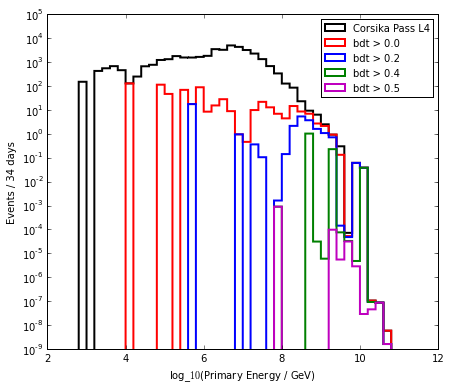

In [43]:
import matplotlib.pyplot as plt

nbins = 50
xmin = 2
xmax = 12
cuts = [0, 0.2, 0.4, 0.5]
cols = ['r','b','g','m']

fig, ax = plt.subplots(ncols=1,figsize=(7,6))

# Plot total corsika passing L4
plt.hist(np.log10(cor.cor_PrimaryEnergy.as_matrix()),
        weights=cor.w.as_matrix(),
        bins=nbins,range=(xmin,xmax),
        histtype='step',
        color = 'black',
        label='Corsika Pass L4',
        lw = 2)

# Plot the corsika per cut
for i in range(len(cuts)):
    cut = cuts[i]
    col = cols[i]
    plt.hist(np.log10(cor[cor.scores>cut].cor_PrimaryEnergy.as_matrix()),
            weights=cor[cor.scores>cut].w.as_matrix(),
            bins=nbins,range=(xmin,xmax),
             color = col,
            histtype='step',
            label = 'bdt > %.1f'%(cut),
            lw = 2)
plt.xlabel(r'log_${10}$(Primary Energy / GeV)')
plt.ylabel(C.lt_label)
plt.legend(loc='upper right',fontsize='medium')
ax.set_yscale('log')
plt.ylim([1e-9,1e5])
plt.savefig('../plots/CorsikaTruth/PrimaryEnegy_vs_bdtcuts.png')


(1e-09, 100000.0)

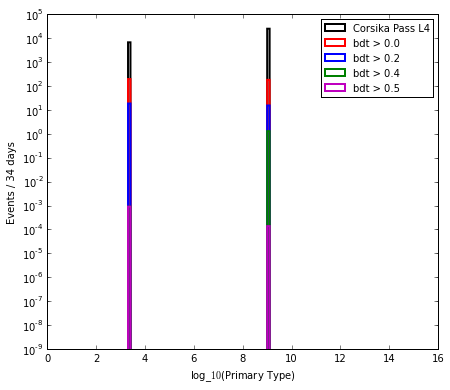

In [68]:
nbins = 150
xmin = 0
xmax = 15
cuts = [0, 0.2, 0.4, 0.5]
cols = ['r','b','g','m']

fig, ax = plt.subplots(ncols=1,figsize=(7,6))

# Plot total corsika passing L4
plt.hist(np.log10(cor.cor_PrimaryType.as_matrix()),
        weights=cor.w.as_matrix(),
        bins=nbins,range=(xmin,xmax),
         histtype='step',
        color = 'black',
        label='Corsika Pass L4',
        lw = 2)

# Plot the corsika per cut
for i in range(len(cuts)):
    cut = cuts[i]
    col = cols[i]
    plt.hist(np.log10(cor[cor.scores>cut].cor_PrimaryType.as_matrix()),
            weights=cor[cor.scores>cut].w.as_matrix(),
            bins=nbins,range=(xmin,xmax),
            color = col,
            histtype='step',
            label = 'bdt > %.1f'%(cut),
            lw = 2)
plt.xlabel(r'log_${10}$(Primary Type)')
plt.ylabel(C.lt_label)
plt.legend(loc='upper right',fontsize='medium')
ax.set_yscale('log')
plt.ylim([1e-9,1e5])
#plt.savefig('../plots/CorsikaTruth/PrimaryEnegy_vs_bdtcuts.png')

In [56]:
# Setup the info
info = {'data' : [cor, cor[cor.scores>0],
                  cor[cor.scores>0.2],
                  cor[cor.scores>0.5]],
        'names'  : ['Corsika L4','bdt > 0','bdt > 0.2', 'bdt > 0.5'],
        'colors'  : ['black','r','b','m'],
        'weights'    : ['w','w','w','w','w'],
        'ls'   : ['solid','solid','solid','solid','solid'],
        'lw' : [1.5,1.5,1.5,1.5,1.5],
        'marker' : [' ',' ',' ',' ',' ']
       }


In [45]:
variables = {'hs_z_travel' : [50,-500,500, 'ztravel','z-travel [m]'],
             'log10(hs_q_tot_pulses)' : [40, 3, 7, 'logqtot','log10(NPE)'],
             'cumuAt600ns' : [25,0,1,'cumuAt600ns','Cumulative @ 600ns'],
             'maxDist' : [25,0,1000,'maxDist','Max Dist 3 Largest Charge DOms'],
             'ImpLF_rchi2' : [50,0,500,'rchi2',r'Reduced $\chi^{2}$'],
             'hs_cogz' : [50,-500,500,'cog_z','COG z [m]'],
             'sqrt(hs_cogx*hs_cogx+hs_cogy*hs_cogy)' : [30,0,600,'cog_rho',r'COG $\rho$'],
             'rho_travel5' : [50,0,1000,'rhotravel5pe',r'$\rho$-travel (> 5 p.e.) [m]'],
             'ndoms_5pe' : [50,0,500,'hitdoms5pe','N Hit Doms (> 5 p.e.)'],
             'nstr_2ndway_5pe' : [60,0,60,'nstr_2ndway_5pe','N Hit Strings (> 5 p.e.)']
            }

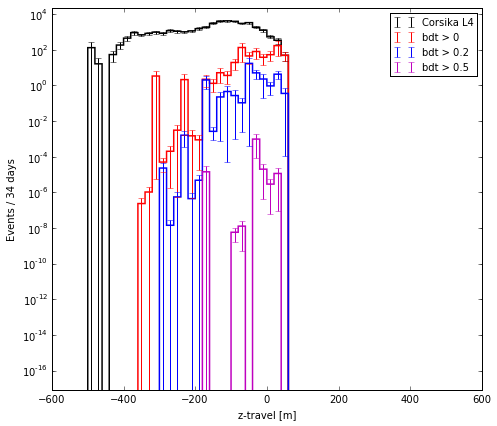

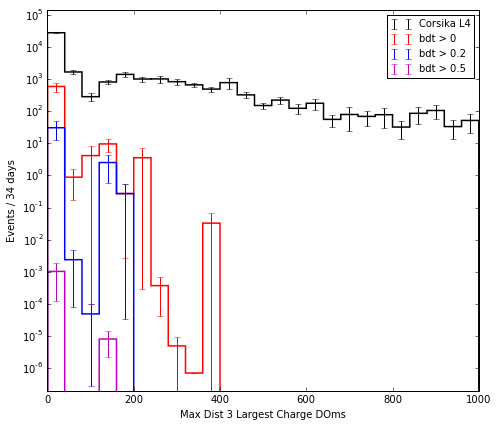

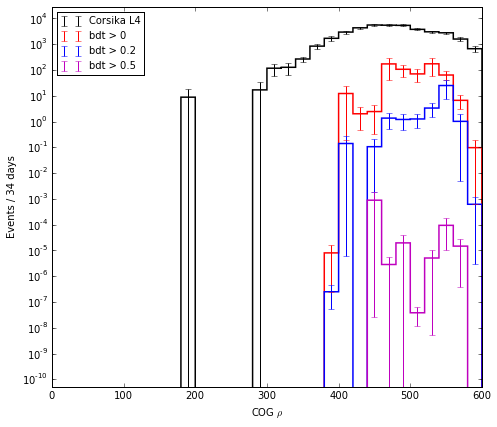

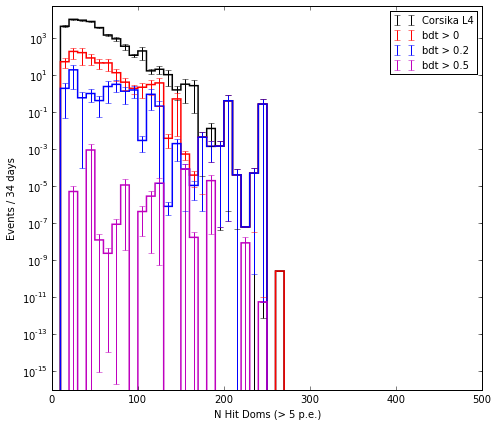

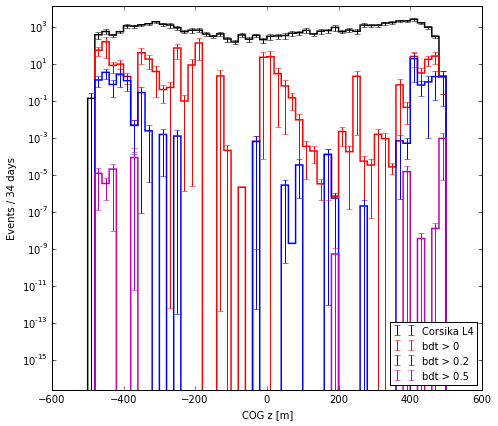

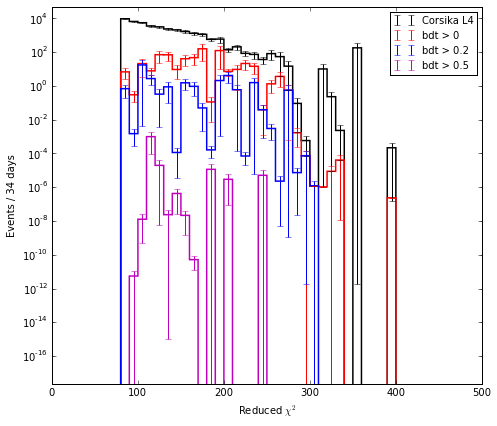

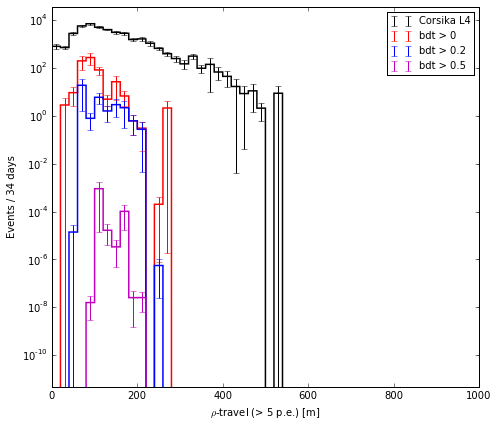

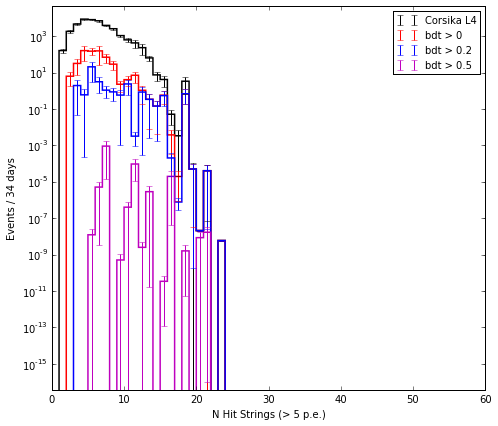

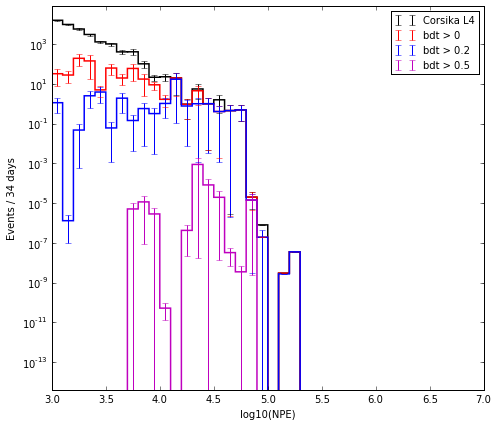

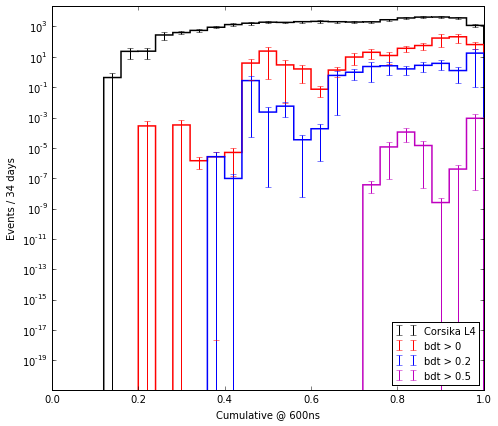

In [69]:
# Plot dat shit

from PlotTool import PlotTool
pt = PlotTool()

for var in variables:
    lims = variables[var]
    fig, ax = plt.subplots(ncols=1,figsize=(7,6))
    ymin = 999999
    ymax = -999999
    
    for i in range(len(info['data'])):
        dt = info['data'][i]
        c  = info['colors'][i]
        name = info['names'][i]
        
        plt.hist(dt[var].as_matrix(),weights=dt['w'].as_matrix(),
                 bins=lims[0],range=(lims[1],lims[2]),
                 lw=1.5,histtype='step',
                 color=c)
        
        bc, be, center = pt.plotErrorBars(dt[var].as_matrix(),dt['w'].as_matrix(),
                                         lims[0], lims[1], lims[2],c,name,' ')
        
        if ymin > bc.min():
            ymin = bc.min()
        if ymax < bc.max():
            ymax = bc.max()
    
        
    plt.xlabel(lims[4])
    plt.ylabel(C.lt_label)
    ax.set_yscale('log')
    plt.ylim([ymin,ymax*5])
    plt.legend(loc='best',fontsize='medium')
    plt.tight_layout()

    plt.savefig('../plots/CorsikaTruth/'+lims[3]+'_multibdtcuts.png')
